## Loading Libraries And Documents

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [151]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import librosa
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [3]:
normal_sample = '/content/drive/MyDrive/data/normal/normal__103_1305031931979_B.wav'
abnormal_sample = '/content/drive/MyDrive/data/abnormal/artifact__201012172012.wav'

## Convert sound wav to 16000 Hz Single Channel

In [4]:
def load_wav_16k_mono(filename):
    wav, sample_rate = librosa.load(filename, sr=16000)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    return wav

In [5]:
wav = load_wav_16k_mono(normal_sample)
nwav = load_wav_16k_mono(abnormal_sample)

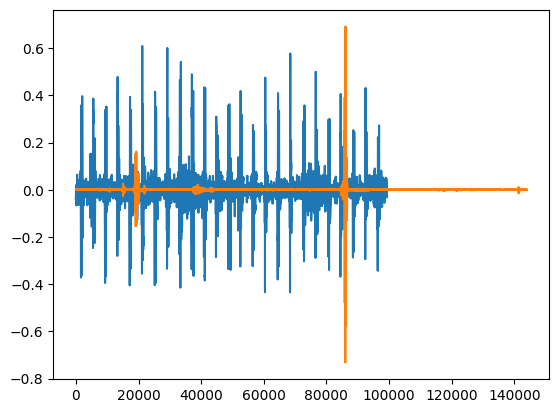

In [6]:
plt.plot(wav)
plt.plot(nwav)
plt.show()

In [7]:
nor = tf.data.Dataset.list_files('/content/drive/MyDrive/data/normal/*.wav')
abnor = tf.data.Dataset.list_files('/content/drive/MyDrive/data/abnormal/*.wav')

In [8]:
normals = tf.data.Dataset.zip((nor, tf.data.Dataset.from_tensor_slices(tf.ones(len(nor)))))
abnormals = tf.data.Dataset.zip((abnor, tf.data.Dataset.from_tensor_slices(tf.zeros(len(abnor)))))
data = normals.concatenate(abnormals)

In [9]:
lengths = []
for file in os.listdir('/content/drive/MyDrive/data/normal'):
    tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/data/normal', file))
    lengths.append(len(tensor_wave))

In [10]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=445872>

## Creating Spectogram

In [11]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

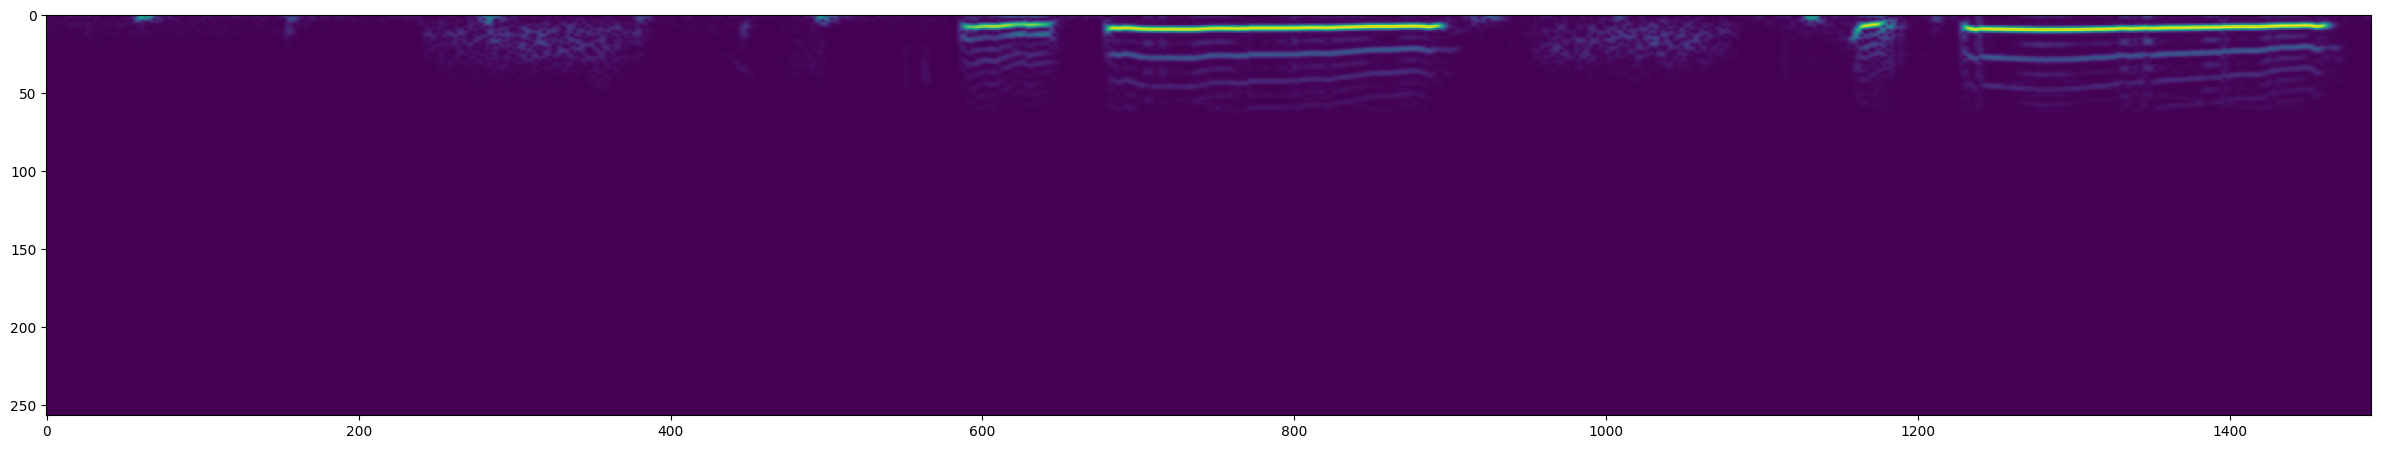

In [12]:
filepath, label = normals.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [13]:
count = 0
dataset = []
for i in data:
  count += 1
  spec,label = preprocess(i[0].numpy(),i[1].numpy())
  dataset.append([spec.numpy(),label])

In [14]:
df = pd.DataFrame(dataset, columns=['Spectogram','Label'])

In [ ]:
df.head()

,Spectogram,Label
0,"[[[3.607433], [3.3427846], [2.4295847], [1.202...",1.0
1,"[[[1.4223163], [2.0099041], [1.8172275], [0.68...",1.0
2,"[[[1.8587315], [2.0664942], [2.0325696], [1.43...",1.0
3,"[[[1.6914866], [1.4451393], [0.85779005], [0.3...",1.0
4,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1.0


In [15]:
X = df['Spectogram']
Y = df['Label']

In [16]:
X[0].shape

(1491, 257, 1)

## Training And Spliting Data

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [19]:
X_train = np.array([np.array(val) for val in X_train])
X_train = tf.cast(X_train , dtype=tf.float32)

X_test = np.array([np.array(val) for val in X_test])
X_test = tf.cast(X_test , dtype=tf.float32)

Y_train = np.array([np.array(val) for val in Y_train])
Y_train = tf.cast(Y_train , dtype=tf.float32)

Y_test = np.array([np.array(val) for val in Y_test])
Y_test = tf.cast(Y_test , dtype=tf.float32)

In [20]:
X_train[0].shape

TensorShape([1491, 257, 1])

## Creating the CNN model using keras

In [22]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2,input_shape=(1491,257,1),activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1490, 256, 16)     80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 745, 128, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 745, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 744, 127, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 372, 63, 32)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 372, 63, 32)       0

In [23]:
hist = model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test))

Epoch 1/20
16/16 [==============================] - 20s 439ms/step - loss: 0.6850 - accuracy: 0.6197 - val_loss: 0.6730 - val_accuracy: 0.6136
Epoch 2/20
16/16 [==============================] - 5s 319ms/step - loss: 0.6609 - accuracy: 0.6499 - val_loss: 0.6571 - val_accuracy: 0.6364
Epoch 3/20
16/16 [==============================] - 5s 317ms/step - loss: 0.6543 - accuracy: 0.6298 - val_loss: 0.6498 - val_accuracy: 0.6250
Epoch 4/20
16/16 [==============================] - 5s 319ms/step - loss: 0.6488 - accuracy: 0.6459 - val_loss: 0.6481 - val_accuracy: 0.6364
Epoch 5/20
16/16 [==============================] - 5s 311ms/step - loss: 0.6462 - accuracy: 0.6398 - val_loss: 0.6465 - val_accuracy: 0.6250
Epoch 6/20
16/16 [==============================] - 5s 327ms/step - loss: 0.6488 - accuracy: 0.6358 - val_loss: 0.6468 - val_accuracy: 0.6136
Epoch 7/20
16/16 [==============================] - 5s 313ms/step - loss: 0.6458 - accuracy: 0.6459 - val_loss: 0.6455 - val_accuracy: 0.6250
Epoch

## Testing Accuracy Of Model

Text(0.5, 1.0, 'Loss Curve')

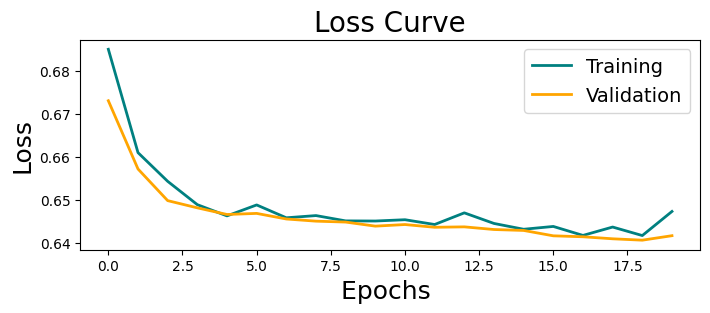

In [24]:
plt.figure(figsize=[8,6])
plt.subplot(211)
plt.plot(hist.history['loss'],'teal',linewidth=2.0)
plt.plot(hist.history['val_loss'],'orange',linewidth=2.0)
plt.legend(['Training', 'Validation'], fontsize=14)
plt.xlabel('Epochs ',fontsize=18)
plt.rc('xtick', labelsize=13)
plt.ylabel('Loss',fontsize=18)
plt.rc('ytick', labelsize=13)
plt.title('Loss Curve',fontsize=20)

Text(0.5, 1.0, 'Accuracy Curve')

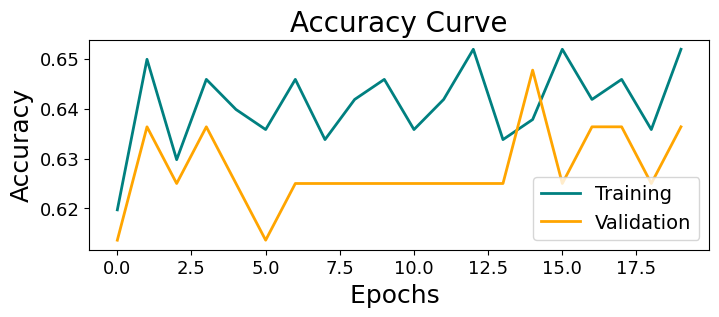

In [25]:
plt.figure(figsize=[8,6])
plt.subplot(212)
plt.plot(hist.history['accuracy'],'teal',linewidth=2.0)
plt.plot(hist.history['val_accuracy'],'orange',linewidth=2.0)
plt.legend(['Training', 'Validation'],fontsize=14)
plt.xlabel('Epochs ',fontsize=18)
plt.rc('xtick', labelsize=13)
plt.ylabel('Accuracy',fontsize=18)
plt.rc('ytick', labelsize=13)
plt.title('Accuracy Curve', fontsize=20)

In [28]:
model.save('/content/drive/MyDrive/models/heartbeat_classifier.h5')

In [29]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

3/3 [==============================] - 0s 62ms/step - loss: 0.6416 - accuracy: 0.6364
Test loss: 0.641613245010376
Test accuracy: 0.6363636255264282


In [32]:
Y_pred = model.predict(X_test)

3/3 [==============================] - 0s 51ms/step


In [40]:
Y_test

<tf.Tensor: shape=(88,), dtype=float32, numpy=
array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 0.], dtype=float32)>

In [43]:
Y_pred = [1 if pred > 0.5 else 0 for pred in Y_pred]

In [44]:
print(classification_report(Y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.16      0.86      0.27         7
           1       0.98      0.62      0.76        81

    accuracy                           0.64        88
   macro avg       0.57      0.74      0.52        88
weighted avg       0.92      0.64      0.72        88



In [48]:
cm = confusion_matrix(Y_pred, Y_test)

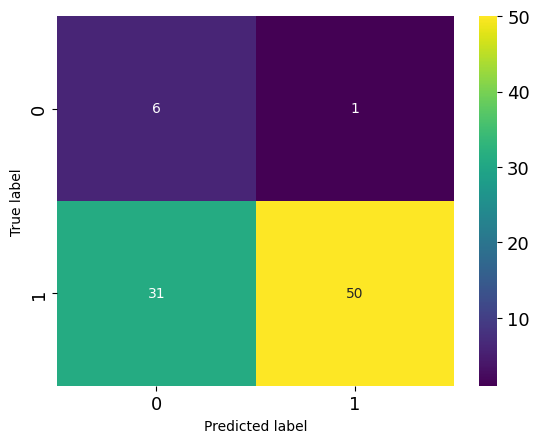

In [62]:
sns.heatmap(cm, annot=True, cmap='viridis')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [70]:
Y_proba = model.predict(X_test)

3/3 [==============================] - 0s 52ms/step


In [92]:
Y_proba = np.array([np.array(val) for val in Y_proba])
Y_proba = tf.cast(Y_proba , dtype=tf.float32)

In [93]:
Y_proba = tf.reshape(Y_proba,[88])

In [94]:
Y_test.shape

TensorShape([88])

In [95]:
Y_proba.shape

TensorShape([88])

In [103]:
Y_proba = [1 if pred > 0.5 else 0 for pred in Y_proba]

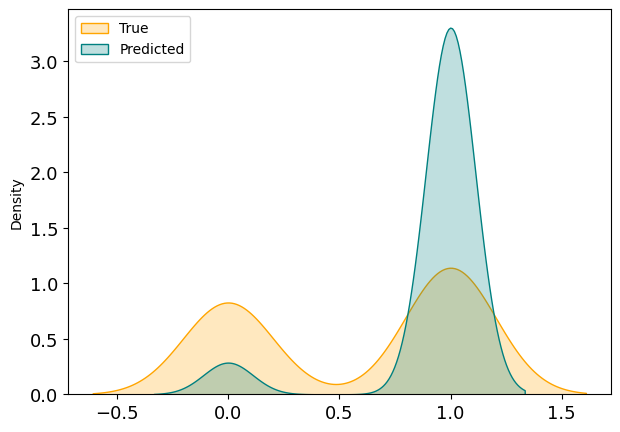

In [149]:
fig, ax = plt.subplots(ncols=1,figsize=(7,5))
sns.kdeplot(Y_test.numpy(), ax=ax, color='orange',fill=True)
sns.kdeplot(Y_proba, ax=ax, color='teal',fill=True)
plt.legend(loc='upper left', labels=['True', 'Predicted'])
plt.show()